In [1]:
import pandas as pd
import numpy as np
import os
os.chdir('../../../../')
print(os.getcwd())
from v2.strategy.indicators.optimal_v2 import Optimal_v2
from v2.model import Trading
from v2.strategy.indicators.param import Param
from v2.strategy.indicators.notebook_utils import fetchIndicators, genDataForAll
from load_config import load_config
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from xgboost import XGBClassifier

/Users/rosscopeland/Desktop/personal/code/vivaldi/back_testing


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RNN, BatchNormalization
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
#adding in indicators
model = Trading(load_config("config.hjson"))
dataset_list = []
for d in model.dfs:
    now = time.time()
    print(d[1])
    cur_dataset = d[0]
    my_inds = fetchIndicators(['bollinger_bands','slope', 'hma', 'variance','pivot_points', 'rsi', 'cci', 'ema', 'delta', 'macd', 'sma', 'smma', 'wma', 'optimal_v2'])
    genDataForAll(cur_dataset, my_inds)
    cur_dataset.dropna(inplace=True)
    mm_scalar = MinMaxScaler()
    # cur_dataset[["rsi", "stosc_k", "stosc_d"]] = mm_scalar.fit_transform(cur_dataset[["rsi", "stosc_k", "stosc_d"]])
    dataset_list.append(cur_dataset)
    print("took {} seconds".format(time.time() - now))
final_dataset = pd.concat(dataset_list)

#first try 172.11971712112427

XBTUSD
took 108.85530185699463 seconds


In [4]:
def filter_optimal(optimal):
    if optimal > 0.8:
        return 2.0
    elif optimal < -0.8:
        return 0.0
    else:
        return 1.0

for dataset, name in model.dfs:
    dataset['optimal'] = dataset.apply(lambda x: filter_optimal(x.optimal), axis=1)

In [5]:
model.dfs[0][0].columns

Index(['time', 'open', 'high', 'low', 'close', 'volume', 'trades',
       'boll_sma_slope', 'boll_upper', 'boll_lower', 'Slope',
       'normal_wma_slope', 'half_period_wma_slope', 'HMA', 'HMA_slope',
       'Variance', 'pp_sma_slope', 'pp_r1', 'pp_s1', 'pp_r2', 'pp_s2', 'pp_r3',
       'pp_s3', 'rsi_smma_u_slope', 'rsi_smma_d_slope', 'RSI',
       'cci_sma_tp_slope', 'CCI', 'EMA', 'EMA_slope', 'Delta',
       'ema_slow_slope', 'ema_fast_slope', 'signal_slope', 'MACD', 'SMA',
       'SMA_slope', 'SMMA', 'SMMA_slope', 'WMA', 'WMA_slope', 'optimal'],
      dtype='object')

In [6]:
#removing irrelavent data like time open high low

# model_data = model.dfs[0][0][["close", "volume", "rsi_diff", "ema_slow", "ema_fast", "macd_diff", "stosc_k", "stosc_d", "slope", "boll_stdev", "boll_sma", "pp_high", "pp_low", "pp_sma", "pp_pp", "optimal"]]
model_data = model.dfs[0][0].drop(["time", "open", "high", "low"], axis=1)
model_data

,close,volume,trades,boll_sma_slope,boll_upper,boll_lower,Slope,normal_wma_slope,half_period_wma_slope,HMA,...,ema_fast_slope,signal_slope,MACD,SMA,SMA_slope,SMMA,SMMA_slope,WMA,WMA_slope,optimal
120,205.568616,0.922000,3,0.434558,212.482134,141.831109,0.272820,0.430070,0.425260,205.868128,...,0.254457,0.238733,-143.226535,177.156622,0.434558,175.508703,0.307503,186.524308,0.430070,1.0
121,206.058598,2.514000,3,0.432032,213.135917,142.462630,0.273779,0.428050,0.421141,206.574916,...,0.255074,0.239390,-143.512412,177.799274,0.432032,175.972172,0.306822,187.170285,0.428050,1.0
122,206.303589,1.188000,1,0.429212,213.736762,143.151753,0.273779,0.425943,0.416204,207.248453,...,0.255641,0.240003,-143.797130,178.444258,0.429212,176.426983,0.306093,187.802138,0.425943,0.0
123,205.671085,3.971000,4,0.418645,214.263307,143.847113,0.273779,0.405448,0.373612,207.865696,...,0.250333,0.235299,-144.074071,179.055210,0.418645,176.850972,0.292933,188.386629,0.405448,1.0
124,204.599747,2.000000,4,0.397830,214.709569,144.565926,0.273779,0.374121,0.308999,208.405894,...,0.241543,0.227438,-144.343260,179.637748,0.397830,177.244839,0.272619,188.924501,0.374121,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1777671,9147.145284,0.002000,1,0.014444,9158.001641,9125.889470,0.003418,0.059967,-0.034622,9150.504519,...,-0.002411,-0.002669,-9146.984413,9141.945556,0.014444,9145.946893,0.000442,9143.767350,0.059967,1.0
1777672,9146.422642,0.187285,5,0.022593,9158.055054,9125.904946,0.003418,0.064778,-0.031465,9150.446763,...,-0.000763,-0.001175,-9146.978321,9141.980000,0.022593,9145.944149,0.003030,9143.849866,0.064778,1.0
1777673,9139.911321,23.300000,36,-0.022593,9158.053575,9125.701981,0.003418,-0.035352,-0.233945,9150.179881,...,-0.032459,-0.029860,-9146.918301,9141.877778,-0.022593,9145.804770,-0.047374,9143.661294,-0.035352,1.0
1777674,9139.155661,0.005033,1,-0.049630,9158.022706,9125.639516,0.003418,-0.088335,-0.340741,9149.793571,...,-0.049248,-0.045072,-9146.880446,9141.831111,-0.049630,9145.722495,-0.073885,9143.584860,-0.088335,1.0


In [7]:
train, test = train_test_split(model_data, test_size=0.2, shuffle=False)

In [8]:
#random sampling to make a better distribution of optimal and not. Not for time series senstive data (LSTM, GRU)
buy_signals = train[train['optimal'] == 2.0]
sell_signals = train[train['optimal'] == 0]

mean_num_singals = int(np.mean([len(buy_signals), len(sell_signals)]))
not_signals = train[train['optimal'] == 1.0]

print(mean_num_singals, len(not_signals))

not_signals_sampled = not_signals.sample(n=mean_num_singals * 4, random_state=69420, axis=0)

balanced_data_buy = pd.concat([not_signals_sampled, buy_signals])
balanced_data_sell = pd.concat([not_signals_sampled, sell_signals])
balanced_data_all = pd.concat([not_signals_sampled, buy_signals, sell_signals])

45928 1330187


In [9]:
#creating 
balanced_data_X = balanced_data_all.drop("optimal", axis=1)
balanced_data_y = balanced_data_all[["optimal"]]

test_X = test.drop("optimal", axis=1)
test_y = test[["optimal"]]

train_X = train.drop("optimal", axis=1)
train_y = train[["optimal"]]

In [16]:
#making more simple classifer as a baseline

clf = XGBClassifier(random_state=69420, n_jobs=-1)#, n_estimators=10)
clf.fit(balanced_data_X.values, balanced_data_y.values, sample_weight=boost_weights)
clf.score(test_X.values, test_y.values)

NameError: name 'boost_weights' is not defined

In [10]:
#weights for resampled and original data

weight = class_weight.compute_class_weight('balanced', np.unique(train_y.to_numpy()[:,0]), train_y.to_numpy()[:,0])
weight = {i : weight[i] for i in range(3)}

balanced_weight = class_weight.compute_class_weight('balanced', np.unique(balanced_data_y.to_numpy()[:,0]), balanced_data_y.to_numpy()[:,0])
balanced_weight = {i : balanced_weight[i] for i in range(3)}

In [27]:
#fix this
lstm_normal_data = model_data.copy()
lstm_X = lstm_normal_data.drop("optimal", axis=1)
lstm_y = lstm_normal_data[["optimal"]]

scalar = MinMaxScaler()
normal_lstm_X = scalar.fit_transform(lstm_X)

normal_lstm_train_X, normal_lstm_test_X, lstm_train_y, lstm_test_y = train_test_split(normal_lstm_X, lstm_y, test_size=0.2, shuffle=False)

normal_lstm_x_train = np.reshape(normal_lstm_train_X, (normal_lstm_train_X.shape[0], 1, normal_lstm_train_X.shape[1]))
normal_lstm_x_test = np.reshape(normal_lstm_test_X, (normal_lstm_test_X.shape[0], 1, normal_lstm_test_X.shape[1]))


In [11]:
#normalizing balanced data
high_low = {}

for col in balanced_data_X.columns:
    high_low[col] = {"high":-sys.maxsize, "low":sys.maxsize}
    high_low[col]["high"] = max(balanced_data_X[col])
    high_low[col]["low"] = min(balanced_data_X[col])

high_low

def normalize_data(column):
    return (column - high_low[column.name]["low"]) / (high_low[column.name]["high"] - high_low[column.name]["low"])
    

normal_balanced_data_X = balanced_data_X.apply(normalize_data)
normal_test_X = test_X.apply(normalize_data)

In [38]:
from keras.optimizers import SGD
opt = SGD(lr=0.001)

#NN
nn_model = Sequential()
nn_model.add(Dense(64, activation='relu'))
nn_model.add(BatchNormalization())
nn_model.add(Dropout(0.3))

nn_model.add(Dense(64, activation='relu'))
nn_model.add(BatchNormalization())
nn_model.add(Dropout(0.3))

nn_model.add(LSTM(128, activation='relu', return_sequences=True))
nn_model.add(BatchNormalization())
nn_model.add(Dropout(0.3))

nn_model.add(Dense(64, activation='relu'))
nn_model.add(BatchNormalization())
nn_model.add(Dropout(0.3))

nn_model.add(Dense(3, activation='sigmoid'))

# opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-5)

nn_model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

checkpoint_filepath = "/Users/rosscopeland/Desktop/personal/code/vivaldi/back_testing/v2/strategy/saved_models/test_nn/"

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
train_X.columns

In [24]:
balanced_data_X.drop(["volume", 'trades', 'boll_sma_slope', 'boll_upper','boll_lower', 'Slope', 'normal_wma_slope', 'half_period_wma_slope','Variance', 'pp_r1', 'pp_s1',
       'pp_r2', 'pp_s2', 'pp_r3', 'pp_s3'], axis=1, inplace=True)
train_X.drop(["volume", 'trades', 'boll_sma_slope', 'boll_upper','boll_lower', 'Slope', 'normal_wma_slope', 'half_period_wma_slope','Variance', 'pp_r1', 'pp_s1',
       'pp_r2', 'pp_s2', 'pp_r3', 'pp_s3'], axis=1, inplace=True)
test_X.drop(["volume", 'trades', 'boll_sma_slope', 'boll_upper','boll_lower', 'Slope', 'normal_wma_slope', 'half_period_wma_slope','Variance', 'pp_r1', 'pp_s1',
       'pp_r2', 'pp_s2', 'pp_r3', 'pp_s3'], axis=1, inplace=True)

In [25]:
train_X.columns

Index(['close', 'HMA', 'HMA_slope', 'pp_sma_slope', 'rsi_smma_u_slope',
       'rsi_smma_d_slope', 'RSI', 'cci_sma_tp_slope', 'CCI', 'EMA',
       'EMA_slope', 'Delta', 'ema_slow_slope', 'ema_fast_slope',
       'signal_slope', 'MACD', 'SMA', 'SMA_slope', 'SMMA', 'SMMA_slope', 'WMA',
       'WMA_slope'],
      dtype='object')

In [33]:
print(type(normal_lstm_x_train))
print(type(lstm_train_y.values))
print(type(balanced_weight))
print(type(normal_lstm_x_test))
print(type(lstm_test_y.values))
print(type(model_checkpoint_callback))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'dict'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'tensorflow.python.keras.callbacks.ModelCheckpoint'>


In [39]:
nn_model.fit(normal_lstm_x_train, lstm_train_y.values, epochs=100, class_weight=weight, validation_data=(normal_lstm_x_test, lstm_test_y.values), callbacks=[model_checkpoint_callback])

Epoch 1/100
44439/44439 [==============================] - 125s 3ms/step - loss: 0.4588 - accuracy: 0.7795 - val_loss: 0.2889 - val_accuracy: 0.9537
Epoch 2/100
44439/44439 [==============================] - 136s 3ms/step - loss: 0.4101 - accuracy: 0.8761 - val_loss: 0.2863 - val_accuracy: 0.9537
Epoch 3/100
 8991/44439 [=====>........................] - ETA: 1:34 - loss: 0.3980 - accuracy: 0.8984

KeyboardInterrupt: 

In [21]:
def insert_buys(row):
    if row.predict_buy > row.predict_sell and row.predict_none and row.predict_buy > 0.8:
        return row.close
    # if row.predict == 2.0 :# and heat_val > 0.6:
    #     return row.close
    else:
        return None

def insert_sells(row):
    if row.predict_sell > row.predict_buy and row.predict_none and row.predict_sell > 0.8:
        return row.close
    # if row.predict == 0.0:
    #     return row.close
    else:
        return None

In [15]:
nn_model.load_weights(checkpoint_filepath)

In [16]:
test.drop("optimal", inplace=True, axis=1)

In [18]:
nn_model.predict(normal_test_X.values)

array([[0.27931193, 0.7000237 , 0.33713955],
       [0.23740849, 0.7013273 , 0.3856169 ],
       [0.11103702, 0.681841  , 0.58227545],
       ...,
       [0.03024945, 0.5606437 , 0.90005946],
       [0.05548573, 0.6350206 , 0.7549541 ],
       [0.08352342, 0.6675425 , 0.6287632 ]], dtype=float32)

In [22]:
test[["predict_sell", "predict_none", "predict_buy"]] = nn_model.predict(normal_test_X.values)
# test["predict_sell"] = clf.predict_proba(test.drop("predict_buy", axis=1).values)
test["buy"] = test.apply(lambda x: insert_buys(x), axis=1)
test["sell"] = test.apply(lambda x: insert_sells(x), axis=1)

In [23]:
first_amnt = test.head(600)
first_amnt = test.iloc[1000:2000]

<Figure size 432x288 with 0 Axes>

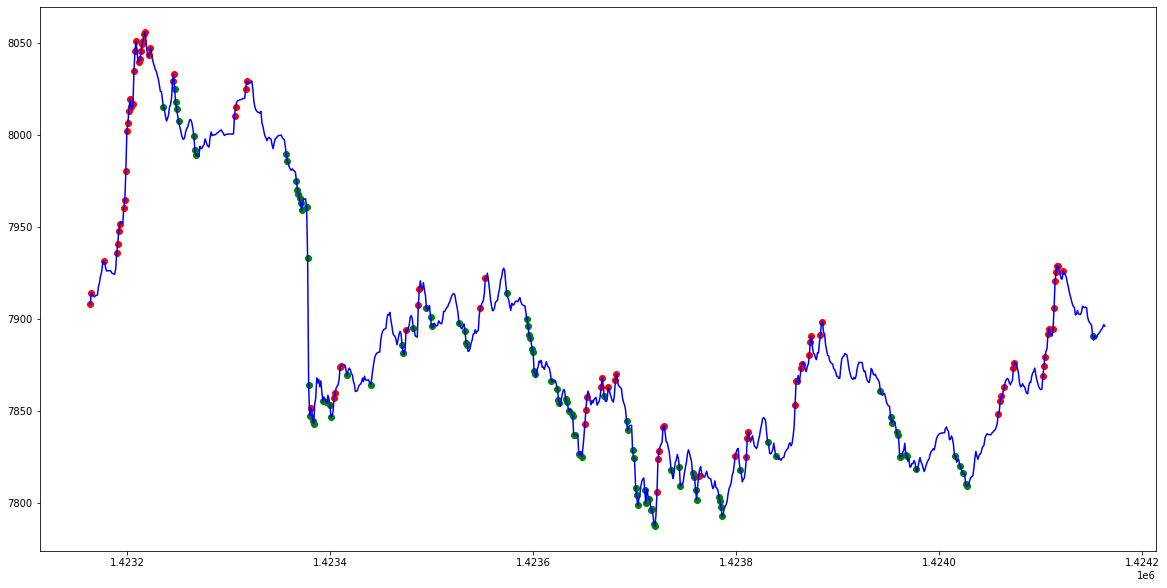

In [24]:
import matplotlib.pyplot as plt
plt.clf()
plt.figure(figsize=(20,10))
plt.scatter(x=first_amnt.index, y=first_amnt['buy'], color='green')
plt.scatter(x=first_amnt.index, y=first_amnt['sell'], color='red')

plt.plot(first_amnt.index, first_amnt['close'], color='blue')
plt.show()